# Time Travel Task Analyses

This notebook contains the analyses necessary to generate the results for the Time Travel Task. The time travel task outputs a binary format log file for space efficiency which first needs to be converted to the appropriate intermediate representations (the iPosition format for test results and an intermediate navigation format for study/test navigation results).

<div class="alert alert-block alert-info">Note: Many of these processing steps can take quite a long time to run as they're processing several gigabytes of data. This issue is compounded if the data is being held on a server. If the intermediate data files have already been generated, it is advisable to skip the steps which regenerate them. These slow code blocks are marked with a note box.</div>

## Data Directories

In order to run most cells in this notebook, these data directories need to be defined (and filled with the appropriate data - see the [Data Conversion](#Data-Conversion) section below to generate the data_output_directory contents).

In [159]:
data_directory = r'C:\Users\Kevin\Documents\GitHub\msl-iposition-pipeline\examples\saved_data\Paper Data (cleaned)'
data_output_directory = r'C:\Users\Kevin\Documents\GitHub\msl-iposition-pipeline\examples\saved_data\Paper Data (iPosition Format)'

generate_intermediate_files = False  # If true, the cells which generate intermediate files will run (they are very slow)

## Data Conversion

First we'll process the data into the appropriate formats.

In [2]:
import cogrecon.core.data_flexing.time_travel_task.time_travel_task_to_iposition as ttt2i

<div class="alert alert-block alert-info">Note: The next cell can take a significant amount of time to run and should only be run on an **empty** directory (otherwise it will append to the files in the directory).

<br><br>To run the cell, set generate_intermediate_files to True (in [Data Directories](#Data-Directories)).
</div>

In [3]:
if 'generate_intermediate_files' in vars() and generate_intermediate_files:
    ttt2i.time_travel_task_to_iposition(data_directory, data_output_directory)

## Test Intermediate Data

For test, there are several primary analyses to be run. First, a basic analysis for the purpose of determining the test-time performance in space or in time are performed. This can be done quite simply with the basic batch processing functions.

Note that these files contain all the output metrics necessary to perform the statistics on Space/Time Misplacement, Number of Incorrect Event Types, Miassignments in Space vs. Time, and Context Boundary Effects.

In [4]:
from cogrecon.core.batch_pipeline import batch_pipeline
from cogrecon.core.data_flexing.time_travel_task.time_travel_task_analytics import summarize_test_data

<div class="alert alert-block alert-info">Note: The next cell can take a significant amount of time to run. If the intermediate data file (*time_travel_task_test_summary.csv* by default) already exists, consider skipping the next cell.<br><br>To run the cell, set generate_intermediate_files to True (in [Data Directories](#Data-Directories)).</div>

In [5]:
if 'generate_intermediate_files' in vars() and generate_intermediate_files:
    summarize_test_data(search_directory=data_directory)  # For Time Travel Task specific analyses

## Test Data Analyses

This subsection contains the analyses which generate basic statistics of interest for the following values:

 * Misplacement in Space
 * Misplacement in Time
 * Number of Events Incorrect
 * Misassignments in Space
 * Misassignments in Time
 * Context-Boundary Effects (in Time)

<div class="alert alert-block alert-info">Note that this section requires the intermediate files (generated above) to execute.</div>

In [6]:
# For Time vs. Space Reconstruction Analyses
if 'generate_intermediate_files' in vars() and generate_intermediate_files:
    batch_pipeline(str(data_output_directory), 'TimeTravelTask_SpaceOnly.csv', data_shape=(4, 10, 3),
                   collapse_trials=False, trial_by_trial_accuracy=False,
                   dimension=3, removal_dim_indicies=[2], actual_coordinate_prefixes=True)
    batch_pipeline(str(data_output_directory), 'TimeTravelTask_TimeOnly.csv', data_shape=(4, 10, 3),
                   collapse_trials=False, trial_by_trial_accuracy=False,
                   dimension=3, removal_dim_indicies=[0, 1], actual_coordinate_prefixes=True)
    batch_pipeline(str(data_output_directory), 'TimeTravelTask_CombinedSpaceAndTime.csv', data_shape=(4, 10, 3),
                   collapse_trials=False, trial_by_trial_accuracy=False,
                   dimension=3, actual_coordinate_prefixes=True)

### Intermediate Files

In [24]:
test_summary_filename = 'time_travel_task_test_summary.csv'
test_cogrecon_space_only_filename = 'TimeTravelTask_SpaceOnly.csv'
test_cogrecon_time_only_filename = 'TimeTravelTask_TimeOnly.csv'

### Visualization Helper Function

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_columns(data, column_names, titles, ylabels, fig_size=(15, 5), separate_plots=True, legend_labels=None, subplot_shape=None):
    # Extract the columns of interest
    trial_num = data['trial']
    columns = [data[c_name] for c_name in column_names]
    
    # Generate useful constants
    trials = list(set(trial_num))
    num_items = 10
    num_participants = len(trial_num)
    means = [[np.mean(column[trial_num == i]) for i in trials] for column in columns]
    std_errs = [[np.std(column[trial_num == i])/np.sqrt(num_participants) for i in trials] for column in columns]
    
    # Visualize each trial-over-trial mean in a subplot
    if separate_plots:
        if subplot_shape is None:
            f, axarr = plt.subplots(1, len(column_names))
        else:
            f, axarr = plt.subplots(*subplot_shape)
            axarr = [j for i in axarr for j in i]
        if len(column_names) == 1:
            axarr = [axarr]
        f.set_size_inches(fig_size)
        for ax, title, mean, std_err, ylabel in zip(axarr, titles, means, std_errs, ylabels):
            ax.errorbar(trials, mean, std_err)
            ax.set_title(title)
            ax.grid(True)
            ax.set_xlabel('Trials')
            ax.set_ylabel(ylabel)
            ax.xaxis.set_ticks(trials)
        plt.show()
    else:
        f = plt.figure()
        f.set_size_inches(fig_size)
        for idx, (title, mean, std_err, ylabel) in enumerate(zip(titles, means, std_errs, ylabels)):
            label = ''
            if legend_labels is not None:
                label = legend_labels[idx]
            plt.errorbar(trials, mean, std_err, label=label)
            plt.title(title)
            plt.grid(True)
            plt.xlabel('Trials')
            plt.ylabel(ylabel)
            plt.gca().xaxis.set_ticks(trials)
            plt.legend()
        plt.show()

### Misplacement (in Space and Time) and Events

In [9]:
import pandas

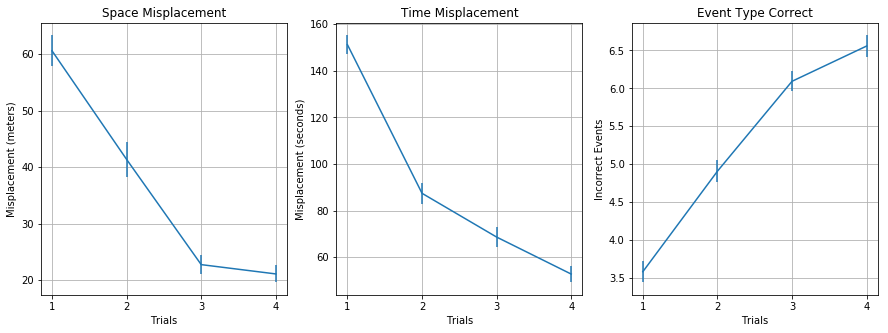

In [10]:
# Load the data
data = pandas.read_csv(test_summary_filename)

columns =  ['space_misplacement', 'time_misplacement', 'event_type_correct_count']
titles = ['Space Misplacement', 'Time Misplacement', 'Event Type Correct']
ylabels = ['Misplacement (meters)', 'Misplacement (seconds)', 'Incorrect Events']
visualize_columns(data, columns, titles, ylabels)

### Misassignments (in Space and Time)

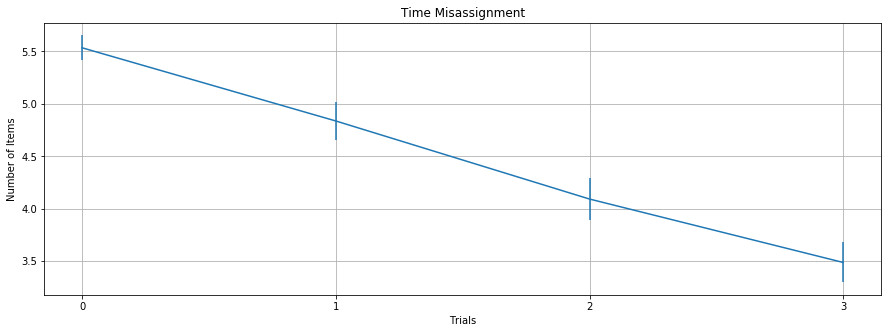

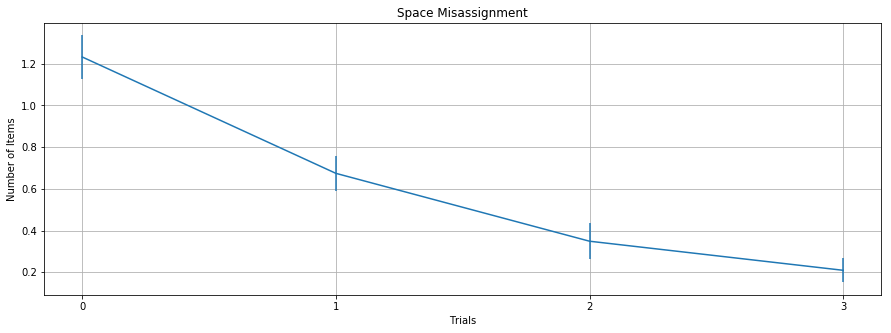

In [11]:
# Load the data
data_time = pandas.read_csv(test_cogrecon_time_only_filename, skiprows=1)
data_space = pandas.read_csv(test_cogrecon_space_only_filename, skiprows=1)

visualize_columns(data_time, ['Accurate Misassignment'], ['Time Misassignment'], ['Number of Items'])
visualize_columns(data_space, ['Accurate Misassignment'], ['Space Misassignment'], ['Number of Items'])

### Context Boundary Effects (in Time)

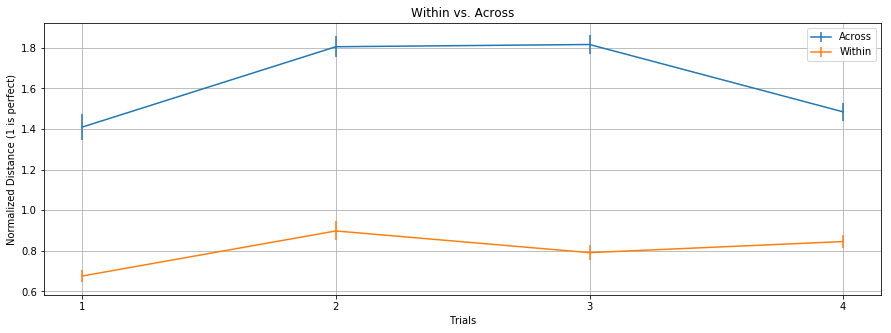

In [12]:
# Load the data
data_time = pandas.read_csv(test_summary_filename)

columns = ['context_crossing_dist_exclude_wrong_color_pairs', 'context_noncrossing_dist_exclude_wrong_color_pairs']
titles = ['', 'Within vs. Across']
legend_labels = ['Across', 'Within']
ylabels = ['Normalized Distance (1 is perfect)', 'Normalized Distance (1 is perfect)']

visualize_columns(data_time, columns, titles, ylabels, separate_plots=False, legend_labels=legend_labels)

## Effect of Context on Misassignment

The analysis of the effect of context on misassignment is not included in any of the packages directly. As a result, we need to do some custom computation to get out these numbers.

First, we need to read the data from the **Accurate Misassignment Pairs** column in the temporal only test output file. Because we're running this in one file, we can simply extract this from the output result rather than reading from file.

In [13]:
import ast
import pandas
import numpy as np
from cogrecon.core.batch_pipeline import get_header_labels

In [14]:
# Load the data
data = pandas.read_csv('TimeTravelTask_TimeOnly.csv', skiprows=1)
misassignment_pairs = [ast.literal_eval(row) for row in data['Accurate Misassignment Pairs']]

Next we'll process the list, counting the number of within vs. across context pairs.

In [15]:
# The pairs which share a context (note that order doesn't matter for this)
within_key = [[0, 1], [1, 0], [2, 3], [3, 2], [4, 5], [5, 4], [6, 7], [7, 6]]
# The items to exclude because they had no contextual information
# thus if they were given temporal information, they would not be a valid misassignment
exclusion_items = [8, 9]

within_list = []
across_list = []
totals_list = []
for i, a in enumerate(misassignment_pairs):
    totals_list.append(len(a))
    within_list.append(0)
    across_list.append(0)
    for el in a:
        if all([el_i not in exclusion_items for el_i in el]):
            if el in within_key:
                within_list[-1] += 1
            else:
                across_list[-1] += 1
within_list_proportion = [float(x)/float(y) if y is not 0 else np.nan for x, y in zip(within_list, totals_list)]
across_list_proportion = [float(x)/float(y) if y is not 0 else np.nan for x, y in zip(across_list, totals_list)]

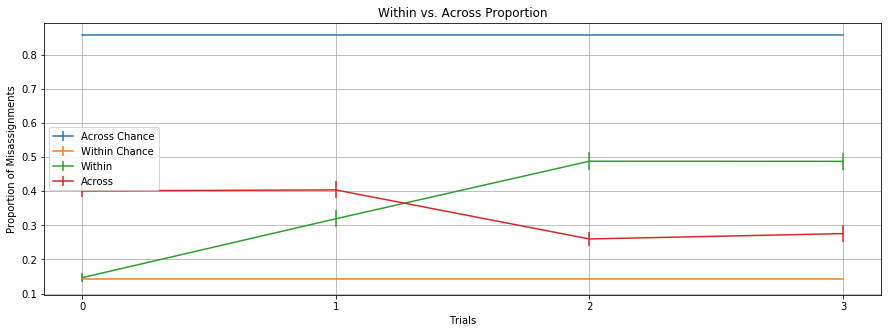

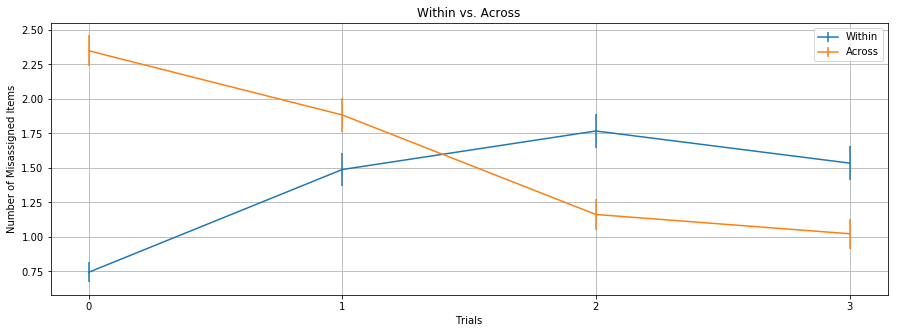

In [16]:
data = pandas.read_csv('TimeTravelTask_TimeOnly.csv', skiprows=1)

num_elements = len(within_list_proportion)

data['within_list_proportion'] = pandas.Series(within_list_proportion)
data['across_list_proportion'] = pandas.Series(across_list_proportion)
data['within'] = pandas.Series(within_list)
data['across'] = pandas.Series(across_list)
data['top'] = pandas.Series([6./7.]*num_elements)
data['bottom'] = pandas.Series([1./7.]*num_elements)

columns_proportion = ['top', 'bottom', 'within_list_proportion', 'across_list_proportion']
titles_proportion = ['', '', '', 'Within vs. Across Proportion']
legend_labels_proportion = ["Across Chance", "Within Chance", "Within", "Across"]
ylabels_proportion = ['', '', '', 'Proportion of Misassignments']

columns = ['within', 'across']
titles = ['', 'Within vs. Across']
legend_labels = ["Within", "Across"]
ylabels = ['', 'Number of Misassigned Items']

visualize_columns(data, columns_proportion, titles_proportion, ylabels_proportion, separate_plots=False, legend_labels=legend_labels_proportion)
visualize_columns(data, columns, titles, ylabels, separate_plots=False, legend_labels=legend_labels)

Next we can save these results to an intermediate file for running statistics.

In [17]:
if 'generate_intermediate_files' in vars() and generate_intermediate_files:
    with open('misassignments_by_context.csv', 'w') as fp:
        fp.write('subID,trial,total_misassignments,within_misassignments,across_misassignments,within_misassignment_proportions,across_misassignment_proportions\n')
        for sid, tr, t, w, a, wp, ap in zip(data['subID'], data['trial'], totals_list,within_list ,across_list,within_list_proportion,across_list_proportion):
            fp.write('{0},{1},{2},{3},{4},{5},{6}\n'.format(sid, tr, t, w, a, wp, ap))

## Navigation Intermediate Data

Next, we can create the summary file for navigation metrics.

In [1]:
from cogrecon.core.data_flexing.time_travel_task.time_travel_task_analytics import summarize_navigation_data

<div class="alert alert-block alert-info">Note: The next cell can take a significant amount of time to run. If the intermediate data file (*time_travel_task_navigation_summary.csv* by default) already exists, consider skipping the next cell.<br><br>To run the cell, set generate_intermediate_files to True (in [Data Directories](#Data-Directories)).</div>

In [1]:
if 'generate_intermediate_files' in vars() and generate_intermediate_files:
    summarize_navigation_data(search_directory=data_directory)  # For Time Travel Task specific analyses

In [3]:
import pandas

# Load the data
data_nav = pandas.read_csv('time_travel_task_navigation_summary.csv')

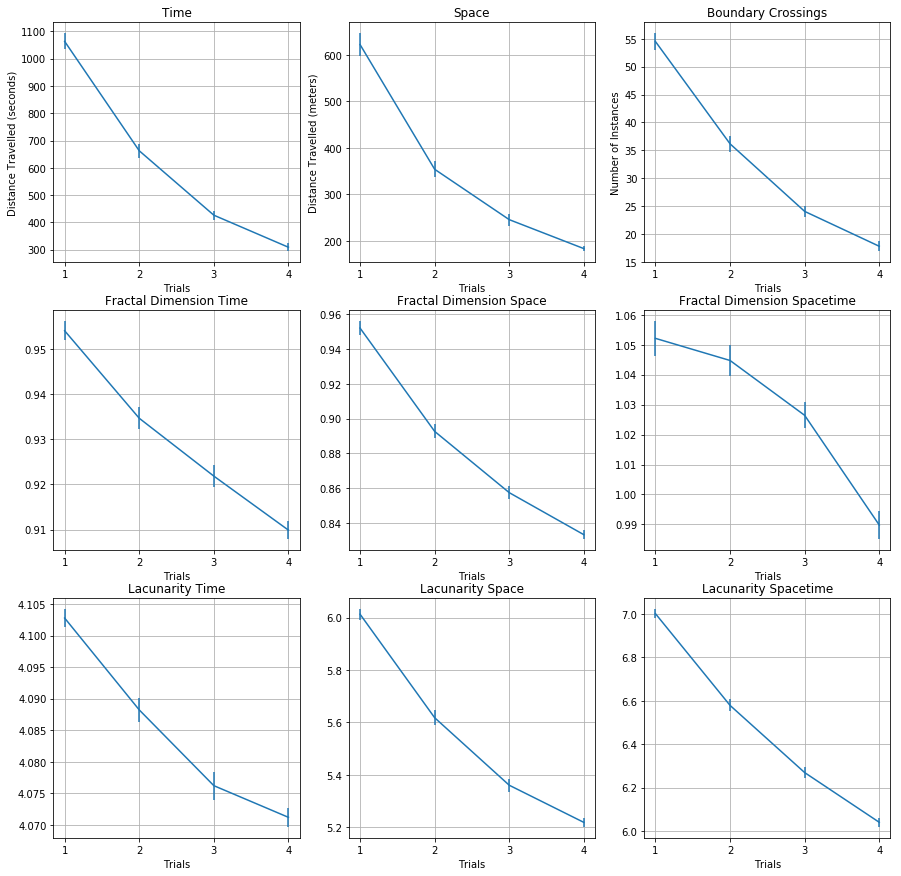

In [6]:
columns = ['time_travelled', 'space_travelled', 'context_boundary_crossings',
           'fd_time', 'fd_space', 'fd_spacetime',
           'lacunarity_time', 'lacunarity_space', 'lacunarity_spacetime']
titles = ['Time', 'Space', 'Boundary Crossings',
          'Fractal Dimension Time', 'Fractal Dimension Space', 'Fractal Dimension Spacetime',
          'Lacunarity Time', 'Lacunarity Space', 'Lacunarity Spacetime']
ylabels = ['Distance Travelled (seconds)', 'Distance Travelled (meters)', 'Number of Instances',
           '', '', '', '', '', '']

visualize_columns(data_nav, columns, titles, ylabels, separate_plots=True, subplot_shape=[3, 3], fig_size=(15, 15))

## Click Order Analysis

This section contains the analysis for examining changes in click order during study. First we define our primary metrics of evaluation. ktcd will give us a tuple of the two distance metrics for a given permutation from the root permutation (i.e. [1,2,3,...,n]).

### Function Definitions

This next section of code is fairly elaborate. It defines the two distance metrics, a function for generating a look-up-table for the probabilities of the given distance coordinates, and a visualization function which animates the trial-over-trial points.

In [7]:
from math import factorial
import scipy.stats as stats
import scipy.spatial as spatial
import numpy as np
import itertools as itools

from tqdm import tqdm
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc, cm

# Decompose a list into contiguous sections (i.e. 2,3,4,1,5,6,8,7 becomes [[2,3,4],[1],[5,6],[8],[7]])
def continuous_decomposition(seq):
    decomposition = [[]]
    for i in seq:
        if len(decomposition[0]) == 0:
            decomposition[0].append(i)
        elif decomposition[-1][-1] == i - 1:
            decomposition[-1].append(i)
        else:
            decomposition.append([i])
    return decomposition

# Returns the normalized contiguous decomposition of a permutation 
# (i.e. (the number of contiguous sublists - 1)/(the length of the permutation - 1))
# If this function returns 0, the list was the elements [1,2,...,len(p)]. If 1, the list had no contiguous sublists.
def contiguous_distance(p):
    return (float(len(continuous_decomposition(p))) - 1) / (len(p) - 1)

# Wraps scipy.stats.kendalltau, setting the target list to [1,2,...,len(p)] and returning just the correlation coefficient
def kendall_tau(p):
    r, _ = stats.kendalltau([x+1 for x in range(0, len(p))], p)
    return r

# Helper function which returns the kendall_tau and contiguous_distance values for a permutation
def kendall_tau_contiguity_distance(p):
    return kendall_tau(p), contiguous_distance(p)

# Helper function which shortens the name of kendall_tau_contiguity_distance to ktcd
def ktcd(p):
    return kendall_tau_contiguity_distance(p)

# This function returns a probability lookup table given a particular size of permutation for the ktcd methods.
# Note that it can take a VERY long time to execute on set sizes larger than 10.
def get_ktcd_probability_lut(perm_size, verbose=True):
    if perm_size > 10:
        print("Warning: Permutation sizes greater than 10 can take a very long time to execute. Set verbose=False to disable this message.")
    target = [i+1 for i in range(0, perm_size)]
    rs0 = []
    rs1 = []
    perm_length = np.prod(list(range(1, len(target) + 1)))
    
    for idx, perm in enumerate(tqdm(itools.permutations(target), total=factorial(len(target)), desc="Computing Permutations for LUT")):
        r, cr = kendall_tau_contiguity_distance(perm)
        rs0.append(r)
        rs1.append(cr)
    cs = []
    rs_zipped = zip(rs0, rs1)
    unique = []
    unique_count = []
    for r0, r1 in zip(rs0, rs1):
        if not (r0, r1) in unique:
            unique.append((r0, r1))
            unique_count.append(rs_zipped.count((r0, r1)))
    rs0_unique, rs1_unique = np.transpose(unique)

    probability_dictionary = {}
    for u, uc in zip(unique, unique_count):
        probability_dictionary[u] = float(uc)/float(perm_length)

    return probability_dictionary

# Function for visualizing a combination of Kentall Tau and Cycle Rearrangement Distance
def visualize_trial_over_trial_3d(root_lut, multi_data, n_interpolated_points=50, interval=33, weights=None, fontsize='x-large'):
    lutA = root_lut

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    keys = lut.keys()
    k0, k1 = np.transpose(keys)
    ax.scatter(k0, k1, lut.values(), c=lut.values(), s=16)
    
    # This function is used for animation
    def update_plot(i, data, scat, txt):
        txt.set_text('Trial:' + str(float(i)/float(n_interpolated_points) + 1))
        pts = []
        for d in data:
            pts.append(list(d[i]))
        scat._offsets3d = np.transpose(pts)
        return scat,

    rgb = cm.get_cmap('viridis')(np.linspace(0.0, 1.0, 4))[np.newaxis, :, :3][0]
    
    points_data = []
    start_points = []
    
    distances = [[], [], [], []]
    for data in tqdm(multi_data, desc="Processing Simulated Data"):
        dists = [kendall_tau_contiguity_distance(p) for p in data]
            
        probs = [lut[d] for d in dists if d in lut.keys()]
        
        d0, d1 = np.transpose(dists)
        for i, (d0t, d1t) in enumerate(zip(d0, d1)):
            distances[i].append((d0t, d1t))
        
        lerp_points_x = []
        lerp_points_y = []
        lerp_points_z = []
        for idx in range(0, len(d0) - 1):
            lerp_points_x += list(np.linspace(d0[idx], d0[idx + 1], n_interpolated_points, endpoint=True))
            lerp_points_y += list(np.linspace(d1[idx], d1[idx + 1], n_interpolated_points, endpoint=True))
            lerp_points_z += list(np.linspace(probs[idx], probs[idx + 1], n_interpolated_points, endpoint=True))

        point_data = zip(lerp_points_x, lerp_points_y, lerp_points_z)
        points_data.append(point_data)
        
        ax.scatter(d0, d1, probs, c=rgb, marker='s', s=50)
        start_points.append([d0[0], d1[0], probs[0]])
    
    x, y, z = np.transpose(start_points)
    scatter_plot = ax.scatter(x, y, z, c=['r'], marker='s', s=50)

    x_means = [np.mean(np.transpose(dist)[0]) for dist in distances]
    y_means = [np.mean(np.transpose(dist)[1]) for dist in distances]
    z_means = [np.mean(pps) for pps in [[lut[d] for d in dists if d in lut.keys()] for dists in distances]]
    mean_scatter_plot = ax.scatter(x_means, y_means, z_means, c='b', marker='o', s=150)
    
    txt = ax.text2D(0.05, 0.95, "Trial 4", transform=ax.transAxes, size=fontsize)
    ani = animation.FuncAnimation(fig, update_plot, frames=len(lerp_points_x), interval=interval,
                              fargs=(points_data, scatter_plot, txt))
    
    rc('animation', html='html5')
    ani.to_html5_video()

    plt.show()
    
    return ani

### Process the Click Order

This section reads the intermediate file and turns the click indicies into a permutation which can be analyzed by the algorithms defined above.

In [8]:
import pandas
import ast

# Load the data
data_nav = pandas.read_csv('time_travel_task_navigation_summary.csv')

inverse = data_nav['inverse']

# Process the lists of indicies
raw_indicies = [ast.literal_eval(row) for row in data_nav['click_order'].values]
sorted_indicies = []
indicies = []

# Simplify the indicies to their ordinal position (i.e. [0, 2, 3, 1, 5, ...])
for row, inv in zip(raw_indicies, inverse):
    if inv:
        sorted_list, index_list = zip(*sorted(zip(row, list(reversed(range(0, len(row)))))))
    else:
        sorted_list, index_list = zip(*sorted(zip(row, list(range(0, len(row))))))
    sorted_indicies.append(sorted_list)
    indicies.append(index_list)

# Remove items 8 and 9 as they had no temporal information
temporal_only_indicies = []
for row in indicies:
    index_list = list(row)
    index_list.remove(8)
    index_list.remove(9)
    temporal_only_indicies.append(index_list)

trials = data_nav['trial']
distances = [ktcd(perm) for perm in temporal_only_indicies]

### Finalize Data Transform

Finally, we transform the data into a NxTxP list where N is the number of participants, T is the number of trials, and P is the length of the permutation.

In [9]:
vis_data = [np.array(temporal_only_indicies)[list(trials.values == i)] for i in [1, 2, 3, 4]]
vis_data = np.transpose(vis_data, axes=(1,0,2))
lut = get_ktcd_probability_lut(8)

Computing Permutations for LUT: 100%|██████████████████████████████████████████| 40320/40320 [00:27<00:00, 1482.08it/s]


### Save the Data

In [10]:
if 'generate_intermediate_files' in vars() and generate_intermediate_files:
    with open('click_order_data.csv', 'w') as fp:
        fp.write('subID,trial,kendall_tau_distance,contiguity_distance\n')
        for sid, tr, kt, c in zip(data_nav['subID'], data_nav['trial'], *np.transpose(distances)):
            fp.write('{0},{1},{2},{3}\n'.format(sid, tr, kt, c))

### Visualize

Finally, call the visualization function. This function interpolates over the trials where the height is the probability given a random permutation, the lighter dots are the earlier trials, and the darker dots are the later trials, and the red dots are an animated interpolation across the trials. Deviating away from the peak probability region indicates a preference towards some permutation with low probability.

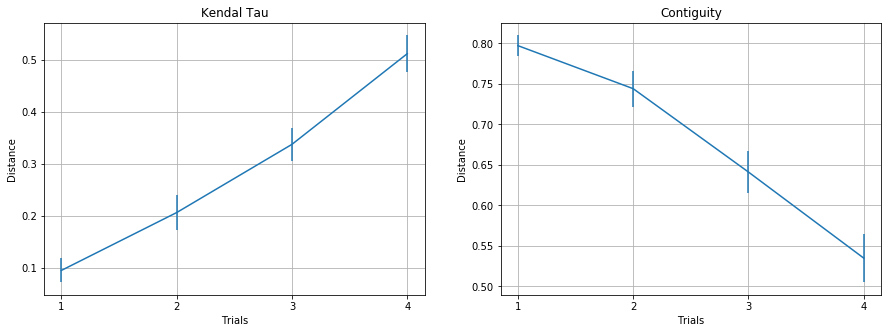

In [11]:
data_dist = pandas.DataFrame()
data_dist['trial'] = trials
data_dist['kendall_tau_distance'] = pandas.Series(list(np.transpose(distances)[0]))
data_dist['contiguity_distance'] = pandas.Series(list(np.transpose(distances)[1]))

columns = ['kendall_tau_distance', 'contiguity_distance']
titles = ['Kendal Tau', 'Contiguity']
ylabels = ['Distance', 'Distance']

visualize_columns(data_dist, columns, titles, ylabels, separate_plots=True)

In [20]:
%%capture
import matplotlib

matplotlib.rcParams['figure.figsize'] = (20,10)
anim = visualize_trial_over_trial_3d(lut, vis_data)

In [21]:
anim

<div class="alert alert-block alert-info">Note: If the above video does not display, it can be viewed here: [https://youtu.be/GytLbbDbLO0](https://youtu.be/GytLbbDbLO0)</div>

## Hierarchical Linear Modeling of Navigation vs. Test Variables

In progress...

This section shows the statistical analysis of the various Study and Test variables and their associated predictive power.

In [1]:
import pandas

# Load all data
data_summary = pandas.read_csv('time_travel_task_test_summary.csv')
data_time = pandas.read_csv('TimeTravelTask_TimeOnly.csv', skiprows=1)
data_space = pandas.read_csv('TimeTravelTask_SpaceOnly.csv', skiprows=1)
data_nav = pandas.read_csv('time_travel_task_navigation_summary.csv')
data_missassignment_by_context = pandas.read_csv('misassignments_by_context.csv')
data_order = pandas.read_csv('click_order_data.csv')

# Fix inconsistent indexing in some files
data_summary['trial'] = [x-1 for x in data_summary['trial'].values]
data_nav['trial'] = [x-1 for x in data_nav['trial'].values]
data_order['trial'] = [x-1 for x in data_order['trial'].values]

# Confirm subID and trial match across all data
assert all([a==b==c==d==e==f for a,b,c,d,e,f in zip(data_order['subID'].values, data_missassignment_by_context['subID'].values, data_nav['subID'].values, data_time['subID'].values, data_space['subID'].values, data_summary['subID'].values)]), 'subIDs do not match in intermediate files'
assert all([a==b==c==d==e==f for a,b,c,d,e,f in zip(data_order['trial'].values, data_missassignment_by_context['trial'].values, data_nav['trial'].values, data_time['trial'].values, data_space['trial'].values, data_summary['trial'].values)]), 'trials do not match in intermediate files'

data = pandas.DataFrame()

# Random Factors
data['subID'] = data_summary['subID']
data['trial'] = data_summary['trial']

# Study Time Factors (independent variables)

# AS) Simple Path Factors
data['space_travelled'] = data_nav['space_travelled']
data['time_travelled'] = data_nav['time_travelled']

# BS) Complex Path Factors
data['fd_time'] = data_nav['fd_time']
data['fd_space'] = data_nav['fd_space']
data['fd_spacetime'] = data_nav['fd_spacetime']
data['lacunarity_time'] = data_nav['lacunarity_time']
data['lacunarity_space'] = data_nav['lacunarity_space']
data['lacunarity_spacetime'] = data_nav['lacunarity_spacetime']

# CS) Context Path Factors
data['context_boundary_crossings'] = data_nav['context_boundary_crossings']

# DS) Order Factors
data['kendall_tau_distance'] = data_order['kendall_tau_distance']
data['contiguity_distance'] = data_order['contiguity_distance']

# Test Time Factors (dependent variables)

# AT) Simple Factors
data['space_misplacement'] = data_summary['space_misplacement']
data['time_misplacement'] = data_summary['time_misplacement']
data['event_type_correct_count'] = data_summary['event_type_correct_count']

# BT) Context Factors
data['across_context_boundary_effect'] = data_summary['context_crossing_dist_exclude_wrong_color_pairs']
data['within_context_boundary_effect'] = data_summary['context_noncrossing_dist_exclude_wrong_color_pairs']
data['context_boundary_effect'] = data_summary['context_crossing_dist_exclude_wrong_color_pairs'] - data_summary['context_noncrossing_dist_exclude_wrong_color_pairs']

# CT) Relational Memory Factors
data['accurate_misassignment_space'] = data_space['Accurate Misassignment']
data['accurate_misassignment_time'] = data_time['Accurate Misassignment']

# DT) Relational Memory and Context Factors
data['within_misassignments'] = data_missassignment_by_context['within_misassignments']
data['across_misassignments'] = data_missassignment_by_context['across_misassignments']

if 'generate_intermediate_files' in vars() and generate_intermediate_files:
    data.to_csv('full_dataset.csv')

### Relationships of Interest

 * Do **Simple or Complex Path Factors (AS, BS)** predict **Simple Factors (AT)**, **Relational Memory Factors (CT)**, or **Relational Memory and Context Factors (DT)**,
 * Does the **Context Path Factor (CS)** predict **Context Factors (BT)** or **Relational Memory and Context Factors (DT)**,
 * Do **Order Factors (DS)** predict **Any Test Factors (AT, BT, CT, DT)**?

### Import R Modules for HLM

Because Python just isn't the right environment for this sort of stats, we'll use nlme in R using rpy2 as an interface.

In [2]:
from rpy2.robjects import pandas2ri
import rpy2.robjects as robjects
import numpy as np

pandas2ri.activate()

Just in case nlme is not properly installed, we can try to install it. If prompts appear, you'll need to accept the install in order to use the next code sections.

In [3]:
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector
from rpy2.robjects import r

utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)

# R package names
packnames = ['nlme']

names_to_install = [x for x in packnames if not rpackages.isinstalled(x)]
if len(names_to_install) > 0:
    utils.install_packages(StrVector(names_to_install))

Now we can convert the data and import the nlme package.

In [4]:
r_dataframe = pandas2ri.py2ri(data)

nlme = rpackages.importr('nlme')

Next we can run the model and print out the t-Table.

In [51]:
model = nlme.lme(r.formula('time_misplacement ~ trial * time_travelled'), random=r.formula('~ trial | subID'), data=r_dataframe)
model_summary = r.summary(model)

# Uncomment this to view all the possible keys
# print(r.summary(model).names)

# We can pick certain keys to ignore during printing
ignore_keys = ['modelStruct', 'dims', 'contrasts', 'coefficients', 'varFix',
               'sigma', 'apVar', 'numIter', 'groups', 'logLik', 
               'call', 'terms', 'fitted', 'method', 'residuals', 
               'fixDF', 'na.action', 'data' , 'corFixed', # 'tTable'
               'BIC', 'AIC'
              ]

for key in model_summary.names:
    if key not in ignore_keys:
        print(r.summary(model).rx2(key))

                            Value    Std.Error  DF   t-value      p-value

(Intercept)           98.05407577 12.826467151 126  7.644667 4.653301e-12

trial                -15.03844638  5.150634912 126 -2.919727 4.151545e-03

time_travelled         0.04267552  0.010861606 126  3.929025 1.397710e-04

trial:time_travelled  -0.01929170  0.007645109 126 -2.523405 1.286633e-02



We can also plot the random coefficients for subID and trial. First we'll extract the data then plot.

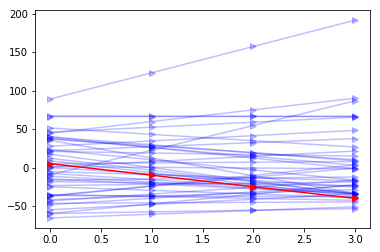

In [52]:
import matplotlib.pyplot as plt
# Get the subject coefficients
subject_lines = pandas2ri.ri2py(r.summary(model).rx2('coefficients').rx2('random').rx2('subID'))
x = np.array([0, 1, 2, 3])
ys = [x*slope + intercept for intercept, slope in subject_lines]

# Get the mean line from the t table
mean_line = pandas2ri.ri2py(r.summary(model).rx2('tTable'))
mean = x*mean_line[1][0] + mean_line[1][1]

# Plot all the lines
for y, label in zip(ys, list(np.linspace(0.0, 1.0, len(ys)))):
    plt.plot(list(x), list(y), c='b', marker='>', alpha=0.25)
    
plt.plot(list(x), list(mean), c='r', marker='>')

plt.show()

In [56]:
print(r.summary(model).rx2('corFixed'))
correlations = pandas2ri.ri2py(r.summary(model).rx2('corFixed'))

                     (Intercept)      trial time_travelled trial:time_travelled

(Intercept)            1.0000000 -0.6827170     -0.8005292            0.2262779

trial                 -0.6827170  1.0000000      0.6978616           -0.6447599

time_travelled        -0.8005292  0.6978616      1.0000000           -0.3870886

trial:time_travelled   0.2262779 -0.6447599     -0.3870886            1.0000000



### Animate trial-over-trial relationship between two variables

We can animate the relationship between two variables using the following code. Note that the next code block will quickly generate the plot object, but we visualize it in the following cell (which can take some time to run).

In [93]:
%%capture

import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

rc('animation', html='html5')
%matplotlib inline

xs = [data['time_travelled'][data['trial'] == n] for n in [0, 1, 2, 3]]
ys = [data['time_misplacement'][data['trial'] == n] for n in [0, 1, 2, 3]]

def update_plot(t):
    if t+1 >= len(xs): # For pausing at the end
        t = 2.99
    index = int(np.floor(t))
    newPoints = np.transpose([xs[index+1], ys[index+1]])
    originalPoints = np.transpose([xs[index], ys[index]])
    nt = t % 1.0
    interpolation = originalPoints*(1-nt) + newPoints*nt
    scat.set_offsets(interpolation)
    return scat,

fig = plt.gcf()

scat = plt.scatter([], [], color='white', edgecolors ='black')
anim = animation.FuncAnimation(fig, update_plot, frames=np.arange(0, 4, 0.01), interval=33)

[plt.scatter(x, y, label=idx+1, alpha=0.5) for idx, (x, y) in enumerate(zip(xs, ys))]
plt.legend()

In [94]:
anim

<div class="alert alert-block alert-info">Note: If the above video does not display, it can be viewed here: [https://youtu.be/NGaQ1cFSXUI](https://youtu.be/NGaQ1cFSXUI)</div>